In [23]:
from google.colab import drive
drive.mount('/content/colabdrive')

Drive already mounted at /content/colabdrive; to attempt to forcibly remount, call drive.mount("/content/colabdrive", force_remount=True).


In [0]:
import os
os.chdir("/content/colabdrive/My Drive/STAT5242/Project/Output/MNIST/[WGAN]image")

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
import tensorflow as tf

In [28]:
tf.__version__

'2.0.0'

In [0]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow.keras import layers
import time
import datetime
from tqdm.autonotebook import tqdm

from IPython import display

In [0]:
TRAIN_BUF = 60000
TEST_BUF = 10000
BATCH_SIZE = 256
noise_dim = 100

In [0]:
# load dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# split dataset
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32")
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32")

# Normalize the images to [-1, 1]
train_images = (train_images - 127.5) / 127.5
test_images = (test_images - 127.5) / 127.5 

# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE)
)

# Implement  our  own  GAN  with  CNN  layers  on  MNIST  data.

## Define the network as tf.keras.model object

In [0]:
class WGAN(tf.keras.Model):
    """ a WGAN class 
    Extends:
        tf.keras.Model
    """

    def __init__(self, **kwargs):
        super(WGAN, self).__init__()
        self.__dict__.update(kwargs)
        self.gen = tf.keras.Sequential(self.gen)
        self.disc = tf.keras.Sequential(self.disc)

    def generate(self, z):
        return self.gen(z)

    def discriminate(self, x):
        return self.disc(x)

    def compute_loss(self, x):
        """ passes through the network and computes loss
        """
        # generating noise from a uniform distribution
        noise = tf.random.normal([self.BATCH_SIZE, noise_dim])
      
        # generate fake picture using noise
        x_gen = self.generate(noise)

        # discriminate real image and fake image
        logits_x = self.discriminate(x)
        logits_x_gen = self.discriminate(x_gen)

        # gradient penalty
        d_regularizer = self.gradient_penalty(x, x_gen)
   
        ### losses 
        # discriminator loss
        # disc_loss = tf.reduce_mean(logits_x) - tf.reduce_mean(logits_x_gen)
        disc_loss = (
            tf.reduce_mean(logits_x)
            - tf.reduce_mean(logits_x_gen)
            + d_regularizer * self.gradient_penalty_weight
        )

      
        # generator loss
        gen_loss = tf.reduce_mean(logits_x_gen)

        return disc_loss, gen_loss

    def compute_gradients(self, x):
        """ passes through the network and computes loss
        """
        ### pass through network
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x)

        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return gen_gradients, disc_gradients

    def apply_gradients(self, gen_gradients, disc_gradients):

        self.gen_optimizer.apply_gradients(
            zip(gen_gradients, self.gen.trainable_variables)
        )
        self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc.trainable_variables)
        )

    def gradient_penalty(self, x, x_gen):
        epsilon = tf.random.uniform([x.shape[0], 1, 1, 1], 0.0, 1.0)
        x_hat = epsilon * x + (1 - epsilon) * x_gen
        with tf.GradientTape() as t:
            t.watch(x_hat)
            d_hat = self.discriminate(x_hat)
        gradients = t.gradient(d_hat, x_hat)
        ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[1, 2]))
        d_regularizer = tf.reduce_mean((ddx - 1.0) ** 2)
        return d_regularizer

    @tf.function
    def train(self, train_x):
        gen_gradients, disc_gradients = self.compute_gradients(train_x)
        self.apply_gradients(gen_gradients, disc_gradients)

## Tensorboard

In [0]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
gen_log_dir = 'logs/[WGAN_MNIST]gradient_tape/' + current_time + '/generator'
disc_log_dir = 'logs/[WGAN_MNIST]gradient_tape/' + current_time + '/discriminator'
gen_summary_writer = tf.summary.create_file_writer(gen_log_dir)
disc_summary_writer = tf.summary.create_file_writer(disc_log_dir)

## Define CNN architecture

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (2, 2), strides=(1, 1), padding='same', use_bias=False, activation="relu"))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', use_bias=False, activation="relu"))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [35]:
new_generator = make_generator_model()
new_generator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_3 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 128)         131072    
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 128)        

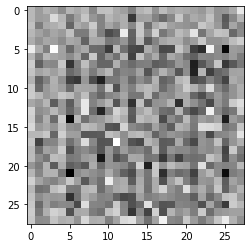

In [36]:
noise = tf.random.normal([1, noise_dim])
new_generated_image = new_generator(noise, training=False)

plt.imshow(new_generated_image[0, :, :, 0], cmap='gray')

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', activation="relu"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))


    return model

In [38]:
new_discriminator = make_discriminator_model()
new_discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)             

In [39]:
new_decision = new_discriminator(new_generated_image)
print (new_decision)

tf.Tensor([[-0.00162076]], shape=(1, 1), dtype=float32)


## Build model

In [0]:
# optimizers
gen_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(0.0005)

# model
model = WGAN(
    gen = new_generator,
    disc = new_discriminator,
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer,
    BATCH_SIZE = BATCH_SIZE,
    gradient_penalty_weight = 10.0
)

## Train the model

In [0]:
n_epochs = 200
num_examples_to_generate = 64
N_TRAIN_BATCHES = int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
# exampled data for plotting results
def generate_and_save_images(epoch, test_input):
    samples = model.generate(test_input)
    fig = plt.figure(figsize=(8,8))

    for i in range(samples.shape[0]):
        plt.subplot(8, 8, i+1)
        plt.imshow(samples[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [0]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

In [0]:
def train(n_epochs):
    for epoch in range(n_epochs):
        # train
        for batch, train_x in tqdm(
            zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
        ):
            model.train(train_x)
 
        # test on holdout
        loss = []
        for batch, test_x in tqdm(
            zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
        ):
            loss.append(model.compute_loss(train_x))
        losses.loc[len(losses)] = np.mean(loss, axis=0)

        # tensorboard
        with gen_summary_writer.as_default():
            tf.summary.scalar('generaotr_loss', losses.gen_loss.values[-1], step=epoch)
        with disc_summary_writer.as_default():
            tf.summary.scalar('discrinimator_loss', losses.disc_loss.values[-1], step=epoch)

        # plot results
        display.clear_output(wait=True)
        print ('Image for epoch {}'.format(epoch + 1))
        generate_and_save_images(epoch + 1,
                                seed)

        print(
            "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
                epoch + 1, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
            )
        )


    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(n_epochs,
                              seed)

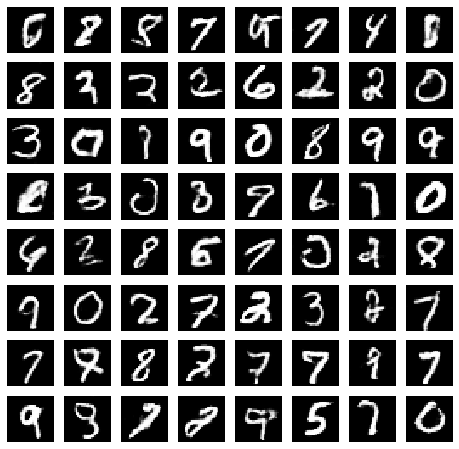

In [23]:
train(n_epochs)

## Open tensorboard

In [56]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-12-16 00:10:34--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.82.169.244, 52.71.139.107, 34.227.147.55, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.82.169.244|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.13M  12.8MB/s    in 1.0s    

2019-12-16 00:10:36 (12.8 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   


In [0]:
LOG_DIR = 'logs/[WGAN_MNIST]gradient_tape'
get_ipython().system_raw('tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format(LOG_DIR))

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [59]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
"import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://96b6d04c.ngrok.io


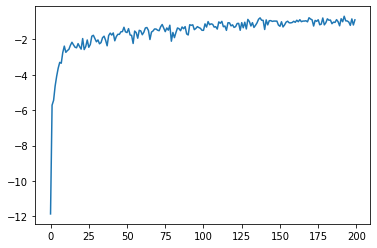

In [25]:
plt.plot(losses.disc_loss.values)

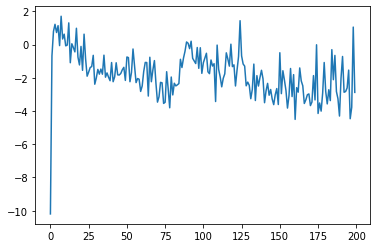

In [24]:
plt.plot(losses.gen_loss.values)